# Analyze NFL Stats with Python

### Overview

This casestudy covers an analysis of NFL statistics from the 2021 season, containing statistics for 32 teams. It covers:
* Data visualisation for game statistics
* Modelling statistics to predict winning teams
* Tuning the model to improve its accuracy
* Determining which statistics were most influential

### Dataset
The dataset we’re working with comprises NFL game stats during the 2021 NFL season. They contain offensive and defensive stats for each game played by each team (including postseason games where applicable) as well as game details such as which teams are competing, the date of the matchup, and the outcome of the game. This dataset was cleaned and modified by Codecademy to include only the stats we needed for this analysis.

Note: the dataset is not loaded into this environment, so running the code a second time will throw an error - however it is currently in its correctly run state.

## Setup and inspection

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Task 1 - Load and inspect the dataset

The first cell loads the libraries needed for the analysis, using common abbreviations for libraries like numpy and pandas, which save time when writing code. Next, the dataset is loaded and saved as the variable `df`, and inspected manually by printing the first few rows with the `.head()` function.

<details>
    <summary style="display:list-item;"><b>Toggle for an overview of the variables in our dataset.</b></summary>

* `symbol`: team name abbreviation
* `team_name`: team name
* `result`: whether this team won (`W`), lost (`L`), or tied (`T`) for this game
* `1stD_offense`: First down conversions by the team's offense
* `TotYd_offense`: Total yards gained by the team's offense
* `PassY_offense`: Total passing yards gained by the team's offense
* `RushY_offense`: Total rushing yards gained by the team's offense
* `TO_offense`: Turnovers committed by the team's offense
* `1stD_defense`: First down conversions allowed by the team's defense
* `TotYd_defense`: Total yards allowed by the team's defense
* `PassY_defense`: Total passing yards allowed by the team's defense
* `RushY_defense`: Total rushing yards allowed by the team's defense
* `TO_defense`: Turnovers in favor of the defensive team

</details>

In [2]:
# load dataset
nfl = pd.read_csv('season_2021.csv')

# inspect first few rows
nfl.head()

,team_name,week,day,date,result,opponent,tm_score,opp_score,1stD_offense,TotYd_offense,PassY_offense,RushY_offense,TO_offense,1stD_defense,TotYd_defense,PassY_defense,RushY_defense,TO_defense
0,Arizona Cardinals,1,Sun,September 12,W,Tennessee Titans,38,13,22,416,280,136,1,17,248,162,86,3
1,Arizona Cardinals,2,Sun,September 19,W,Minnesota Vikings,34,33,21,474,371,103,2,22,419,242,177,0
2,Arizona Cardinals,3,Sun,September 26,W,Jacksonville Jaguars,31,19,23,407,316,91,1,20,361,202,159,4
3,Arizona Cardinals,4,Sun,October 3,W,Los Angeles Rams,37,20,27,465,249,216,0,24,401,280,121,2
4,Arizona Cardinals,5,Sun,October 10,W,San Francisco 49ers,17,10,20,304,210,94,1,19,338,186,152,1


### Task 2 - Summarise the outcome variable

The outcome variable `result` can be summarised using `.value_counts()`, which produces a summed count of the number of times each value is found in the dataset.

In [3]:
# check result value counts
nfl.result.value_counts()

W    284
L    284
T      2
Name: result, dtype: int64

This code reveals that the `result` variable is encoded in three levels: win (`W`), loss (`L`), or tie (`T`). As each game was played by two teams, this also reveals that there were 285 games played, and that one of the games was a tie.

### Task 3 - Re-encoding the result variable

The `result` variable therefore poses two problems:
* Having one very small group can cause issues with the accuracy, or even the ability to function, of a regression model.
* The regression algorithm requires a numerically coded outcome variable (`result` is currently encoded with letters)

This can be solved using the `.replace()` function, which allows us to group the tied game with the losses (neither team won that match after all), and convert the wins to 1 and the losses to 0. This will produce two groups with very similar sample sizes, which is ideal for regression modelling.

In [4]:
# nested dictionary to encode alphanumeric values to numeric values
result_encoder = {'result': {'W': 1, 'T': 0, 'L': 0}}

# encode result column using encoder
nfl.replace(result_encoder, inplace = True)

# check result value counts
nfl.result.value_counts()

0    286
1    284
Name: result, dtype: int64

### Task 4 - Data visualisation of the statistics

The `stat` variable has been set to `1stD_offense` by default. The code below also provides a list of the statisics found in the dataset, which can be subbed in for `1stD_offense` to create a new boxplot.

`sns.boxplot()` can be used to create a boxplot of `stat`, split by wins and losses. This boxplot shows the difference in the frequency of that particular statistic (in this case, 1st down conversions by the offence) depending on if the team won or lost a match.

This boxplot shows:
* First down conversions by the offense are typically between 12 and 33 in winning games (as depicted by the T-shaped ends of the plot). 
* The middle 50% of winning games appears to cover about 20 to 26 first down conversions (as depicted by the orange box).
* The middle line indicates a median of about 23 first down conversions by the winning team.

And when compared to losing games, the winning team typically has a higher number of first downs.

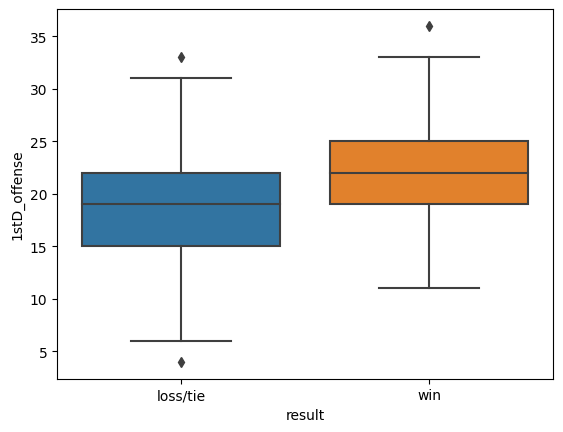

Index(['1stD_offense', 'TotYd_offense', 'PassY_offense', 'RushY_offense',
       'TO_offense', '1stD_defense', 'TotYd_defense', 'PassY_defense',
       'RushY_defense', 'TO_defense'],
      dtype='object')


In [7]:
# change stat to view plot
stat = '1stD_offense'

# box plot of stat
stat_plot = sns.boxplot(x = nfl.result, y = stat, data = nfl)

# plot labels
stat_plot.set_xticklabels(['loss/tie','win'])
plt.show()
# list feature names
print(nfl.columns[8:])

The trend found with all of the stats is that winning teams have higher offensive stats on average (more opportunities to score points) and lower defensive stats on average (fewer opportunities for the opponent to score points). This should indicate a strong relationship between these statistics and the game's result, and should make for a fairly straightforward pattern for the algorithm to learn.

## Data Preparation

### Task 5 - Standardize features

Before creating the regression model, the data needs to be prepared by standardizing the statistics. This code saves the stats to a variable (`features`) and saves the scaling function as `scaler`. 

In [8]:
# select feature variables to be scaled
features = nfl.iloc[:,8:]
scaler = StandardScaler()

# fit the transformer to the features
scaler.fit(features)

# transform and save as X
X = scaler.transform(features)

The statistics are standardised by subtracting the mean and dividing by the standard deviation. This results in all of the statistics having a mean of 0 and a standard deviation of 1. As well as this:
* All of the stats are now in the same units, which means they can all be compared to one another.
* Tuning techniques that require standardisation can now be used to improve prediction model accuracy.

### Task 6 - Save game outcomes (the outcome variable `result`)

Saving the game outcome variable as `y` is useful as it means it can be referred to later on.

In [9]:
# save result variable as y
y = nfl.result

### Task 7 - Split into training and testing data

We need to randomly split the data into two groups:
* **training data:** we'll use this data to train our model to recognize winning games from patterns in the game stats.
* **testing data:** we'll use this data to check our model's accuracy.

The `train_test_split()` function can be used to split the data - the parameters needed are the features (`X`), results (`y`), `test_size`, which is the proportion of data reserved for testing (0.5), and `random_state` (set to 42).

In [13]:
# create train-test split of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

## Analysis

### Task 8 - Run the model

The code below creates a logistic regression model and trains it to the data that was set aside as training data by the `train_test_split()` function in task 7.

In [4]:
# create the classifier
lrc = LogisticRegression()

# fit classifier to the training data
lrc.fit(X_train, y_train)

NameError: name 'X_train' is not defined

### Task 9 - Check model accuracy

With our classifier fitted (trained) to the training data, we can use the trained classifier to make predictions on the test data. 
This is done by passing the test features as a parameter of the `lrc.predict()` function, which has also been saved as `y_pred`.

To check the percentage of outcomes predicted correctly by the model, `y_pred` and `y_test` are passed into the `accuracy_score()` function.

In [17]:
# predict with the classifier using the .predict() function
y_pred = lrc.predict(X_test)

# view the model accuracy with the accuracy_score() function
accuracy_score(y_pred, y_test)

0.8280701754385965

This shows that the model correctly predicted the game outcome for 82.8% of games in the test set.

### Task 10 - Optimize by tuning hyperparameters

The model performance can be improved by studying how different parameters affect its performance - e.g. `penalty` and `C` from `LogisticRegression`.

* `penalty` imposes a regularization penalty on the model for having too many variables. Our options generally are `l1` and `l2` regularization.
* `C` is the inverse of regularization strength. It is applying a penalty to increasing the magnitude of parameter values in order to reduce overfitting.

The following code runs a logistic regression on our same data and gets an accuracy score for each combination of `penalty` and `C`.

In [18]:
# create a list of penalties
penalties = ['l1', 'l2']
# create a list of values for C
C = [0.01, 0.1, 1.0, 10.0, 1000.0]

for penalty in penalties:
    for c in C:

        # instantiate the classifier
        lrc_tuned = LogisticRegression(penalty=penalty, C=c, solver='liblinear')

        # fit the classifier to the training data
        lrc_tuned.fit(X_train, y_train)
        
        # predict with the classifier using the .predict() function
        y_pred = lrc_tuned.predict(X_test)

        # view the model accuracy with the accuracy_score() function
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_rd = round(accuracy*100,1)
        
        # print accuracy for each combination of penalty and C
        print(f'Accuracy: {accuracy_rd}% | penalty = {penalty}, C = {c}')

Accuracy: 52.3% | penalty = l1, C = 0.01
Accuracy: 84.6% | penalty = l1, C = 0.1
Accuracy: 83.2% | penalty = l1, C = 1.0
Accuracy: 82.5% | penalty = l1, C = 10.0
Accuracy: 82.5% | penalty = l1, C = 1000.0
Accuracy: 80.4% | penalty = l2, C = 0.01
Accuracy: 83.5% | penalty = l2, C = 0.1
Accuracy: 82.8% | penalty = l2, C = 1.0
Accuracy: 82.5% | penalty = l2, C = 10.0
Accuracy: 82.5% | penalty = l2, C = 1000.0


These accuracy codes are very similar to the original accuracy score - this is partly due to the fact that `LogisticRegression` automatically uses `penalty = l2` and `C = 1.0`. Changing the hyperparameters to `penalty = l1` and `C = 0.1` in this circumstance increases the accuracy of the model from 82.8% to 84.6%.

### Task 11 - Optimize by changing test size

Another method of parameter tuning is changing the test size of the train-test split. 

In [19]:
# optimal penalty and C
penalty = 'l1'
C = 0.1

# create a list of test_sizes
test_sizes = [val/100 for val in range(20,36)]

for test_size in test_sizes:

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # instantiate the classifier
    lrc_tts = LogisticRegression(penalty = penalty, C = C, solver='liblinear')

    # fit the classifier to the training data
    lrc_tts.fit(X_train, y_train)

    # predict with the classifier using the .predict() function
    y_pred = lrc_tts.predict(X_test)

    # view the model accuracy with the accuracy_score() function
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_rd = round(accuracy*100,1)
    
    # print accuracy for each combination of penalty and test size
    print(f'Accuracy: {accuracy_rd}% | test size = {test_size}')

Accuracy: 87.7% | test size = 0.2
Accuracy: 87.5% | test size = 0.21
Accuracy: 87.3% | test size = 0.22
Accuracy: 87.9% | test size = 0.23
Accuracy: 88.3% | test size = 0.24
Accuracy: 88.8% | test size = 0.25
Accuracy: 87.9% | test size = 0.26
Accuracy: 88.3% | test size = 0.27
Accuracy: 88.1% | test size = 0.28
Accuracy: 88.6% | test size = 0.29
Accuracy: 87.1% | test size = 0.3
Accuracy: 87.6% | test size = 0.31
Accuracy: 86.9% | test size = 0.32
Accuracy: 87.3% | test size = 0.33
Accuracy: 86.1% | test size = 0.34
Accuracy: 86.0% | test size = 0.35


The output indicates that the accuracy was improved the most with a test size of 0.25 - it was improved from 84.6% to 88.8%.

### Task 12 - Save the optimized model

The code below saves the optimized parameters (`test_size`, `penalty`, and `C`) found above into a final model which is saved as `optLr`. `random_state` is still set as 42.

In [20]:
# set the test size and hyperparameters
test_size = 0.25
penalty = "l1"
C = 0.1

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 42)

# instantiate the classifier
optLr = LogisticRegression(penalty = penalty, C = C, solver='liblinear')

# fit the classifier to the training data
optLr.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

### Task 13 - Examine feature importance
The next step is to find out which stats were most important to the model predicting wins. The absolute values of the model coefficients are saved as `importance`.

These absolute values are then visualized in a bar chart, which can be used to establish which statistic had the most importance in the predicting ability of the model.

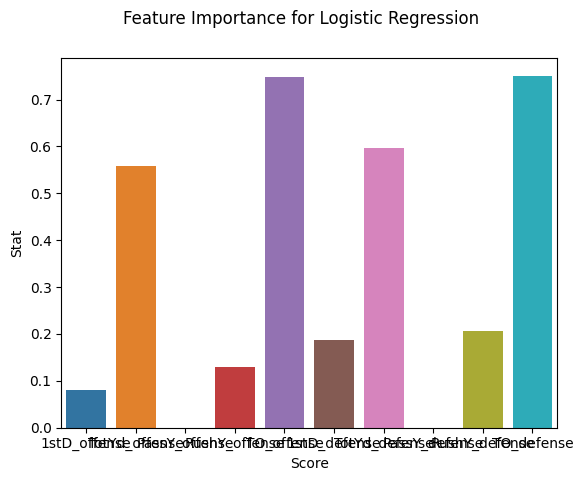

Feature: 1stD_offense, Score: 0.08
Feature: TotYd_offense, Score: 0.56
Feature: PassY_offense, Score: 0.0
Feature: RushY_offense, Score: 0.13
Feature: TO_offense, Score: 0.75
Feature: 1stD_defense, Score: 0.19
Feature: TotYd_defense, Score: 0.6
Feature: PassY_defense, Score: 0.0
Feature: RushY_defense, Score: 0.21
Feature: TO_defense, Score: 0.75


In [21]:
# get importance
importance = abs(optLr.coef_[0])

# visualize feature importance
sns.barplot(x = features.columns, y = importance)

# add labels and titles
plt.suptitle('Feature Importance for Logistic Regression')
plt.xlabel('Score')
plt.ylabel('Stat')
plt.show()


# summarize feature importance
for i,v in enumerate(importance.round(2)):
    print(f'Feature: {features.columns[i]}, Score: {v}')

This chart indicates that the most important stats in the model were turnovers: `TO_offense` and `TO_defense` both had an absolute value of 0.75.

## Conclusion

### Task 13 - Try your model on new data

The model can also be tested on singular team data from 2022 - this data can be farmed from Pro Football Reference using the `get_new_data()` function. [Pro Football Reference](https://www.pro-football-reference.com/).

In [22]:
# set team abbreviation (in capitals) and year
team = 'Dallas Cowboys'
year = 2022

# use helper function to pull new data
from helper import get_new_data
new_data = get_new_data(team=team, year=year)

# view head of new data
new_data.head()

,team_name,week,day,date,result,opponent,tm_score,opp_score,1stD_offense,TotYd_offense,PassY_offense,RushY_offense,TO_offense,1stD_defense,TotYd_defense,PassY_defense,RushY_defense,TO_defense
0,Dallas Cowboys,1,Sun,September 11,0,Tampa Bay Buccaneers,3,19,12,244,173,71,1,18,347,195,152,1
1,Dallas Cowboys,2,Sun,September 18,1,Cincinnati Bengals,20,17,19,337,230,107,1,19,254,165,89,0
2,Dallas Cowboys,3,Mon,September 26,1,New York Giants,23,16,23,391,215,176,0,22,336,169,167,1
3,Dallas Cowboys,4,Sun,October 2,1,Washington Commanders,25,10,15,279,217,62,0,17,297,155,142,2
4,Dallas Cowboys,5,Sun,October 9,1,Los Angeles Rams,22,10,10,239,76,163,0,14,323,285,38,3


In [23]:
# select just the game stats
new_X = new_data.loc[:,features.columns]

# standardize using original data's scaling
new_X_sc = scaler.transform(new_X)

In [24]:
# get new predictions
new_preds = optLr.predict(new_X_sc)

# get actual results and set type to float
new_results = new_data['result'].astype(float)

# get accuracy score for new data
acc_score = accuracy_score(new_results, new_preds)

In [25]:
# select only game data
col_names = ['day', 'date', 'result', 'opponent', 'tm_score', 'opp_score']
game_data = new_data.loc[:,col_names]
# create comparison table
comp_table = game_data.assign(predicted = new_preds,
                              actual = new_results.astype(int))

In [26]:
# print title and table
print(f'Predicted Wins vs Actual Wins for {team} in {year}')
comp_table

Predicted Wins vs Actual Wins for Dallas Cowboys in 2022


,day,date,result,opponent,tm_score,opp_score,predicted,actual
0,Sun,September 11,0,Tampa Bay Buccaneers,3,19,0,0
1,Sun,September 18,1,Cincinnati Bengals,20,17,1,1
2,Mon,September 26,1,New York Giants,23,16,1,1
3,Sun,October 2,1,Washington Commanders,25,10,1,1
4,Sun,October 9,1,Los Angeles Rams,22,10,1,1
5,Sun,October 16,0,Philadelphia Eagles,17,26,0,0
6,Sun,October 23,1,Detroit Lions,24,6,1,1
7,Sun,October 30,1,Chicago Bears,49,29,1,1
8,Sun,November 13,0,Green Bay Packers,28,31,0,0
9,Sun,November 20,1,Minnesota Vikings,40,3,1,1


In [27]:
# print accuracy
print(f'\nCurrent Accuracy Score: ' + str(round(acc_score*100,1)) + '%')


Current Accuracy Score: 89.5%
